In [150]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Import tqdm for progress bar
from tqdm.auto import tqdm

In [151]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

In [152]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

In [153]:
from pathlib import Path

img_file_paths = get_img_files(r"C:\Users\ivanc\maskrcnn\train\images")
annotation_file_paths = list(Path(r"C:\Users\ivanc\maskrcnn\train\labelme_annotations").glob('*.json'))

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image File": [file.name for file in img_file_paths], 
              "Annotation File":[file.name for file in annotation_file_paths]}).head()


,Image File,Annotation File
0,06VM8ESXIQVJVXJ6KDCTI2QG.jpg,06VM8ESXIQVJVXJ6KDCTI2QG.json
1,06VM8ESXIQVJVXJ6KDCTI2QG_aug_0.jpg,06VM8ESXIQVJVXJ6KDCTI2QG_aug_0.json
2,06VM8ESXIQVJVXJ6KDCTI2QG_aug_1.jpg,06VM8ESXIQVJVXJ6KDCTI2QG_aug_1.json
3,06VM8ESXIQVJVXJ6KDCTI2QG_aug_2.jpg,06VM8ESXIQVJVXJ6KDCTI2QG_aug_2.json
4,06VM8ESXIQVJVXJ6KDCTI2QG_aug_3.jpg,06VM8ESXIQVJVXJ6KDCTI2QG_aug_3.json


In [154]:
img_file_paths_valid = get_img_files(r"C:\Users\ivanc\maskrcnn\valid\images")
annotation_file_paths_valid = list(Path(r"C:\Users\ivanc\maskrcnn\valid\labelme_annotations").glob('*.json'))

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image File": [file.name for file in img_file_paths_valid], 
              "Annotation File":[file.name for file in annotation_file_paths_valid]}).head()

,Image File,Annotation File
0,5PVY2BNIFLW14Y1M4D1VSQ92.jpg,5PVY2BNIFLW14Y1M4D1VSQ92.json
1,Banana28.jpg,Banana28.json
2,Banana30.jpg,Banana30.json
3,Banana48.jpg,Banana48.json
4,Banana5.jpg,Banana5.json


In [155]:
# Create a dictionary that maps file names to file paths
img_dict = {file.stem : file for file in img_file_paths}


# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 9350


,0
06VM8ESXIQVJVXJ6KDCTI2QG,C:\Users\ivanc\maskrcnn\train\images\06VM8ESXIQVJVXJ6KDCTI2QG.jpg
06VM8ESXIQVJVXJ6KDCTI2QG_aug_0,C:\Users\ivanc\maskrcnn\train\images\06VM8ESXIQVJVXJ6KDCTI2QG_aug_0.jpg
06VM8ESXIQVJVXJ6KDCTI2QG_aug_1,C:\Users\ivanc\maskrcnn\train\images\06VM8ESXIQVJVXJ6KDCTI2QG_aug_1.jpg
06VM8ESXIQVJVXJ6KDCTI2QG_aug_2,C:\Users\ivanc\maskrcnn\train\images\06VM8ESXIQVJVXJ6KDCTI2QG_aug_2.jpg
06VM8ESXIQVJVXJ6KDCTI2QG_aug_3,C:\Users\ivanc\maskrcnn\train\images\06VM8ESXIQVJVXJ6KDCTI2QG_aug_3.jpg


In [156]:
img_dict_valid = {file.stem : file for file in img_file_paths_valid}

# Print the number of image files
print(f"Number of Images: {len(img_dict_valid)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict_valid, orient='index').head()

Number of Images: 100


,0
5PVY2BNIFLW14Y1M4D1VSQ92,C:\Users\ivanc\maskrcnn\valid\images\5PVY2BNIFLW14Y1M4D1VSQ92.jpg
Banana28,C:\Users\ivanc\maskrcnn\valid\images\Banana28.jpg
Banana30,C:\Users\ivanc\maskrcnn\valid\images\Banana30.jpg
Banana48,C:\Users\ivanc\maskrcnn\valid\images\Banana48.jpg
Banana5,C:\Users\ivanc\maskrcnn\valid\images\Banana5.jpg


In [157]:
# Create a generator that yields Pandas DataFrames containing the data from each JSON file
cls_dataframes = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_file_paths))

# Concatenate the DataFrames into a single DataFrame
annotation_df = pd.concat(cls_dataframes, ignore_index=False)

# Assign the image file name as the index for each row
annotation_df['index'] = annotation_df.apply(lambda row: row['imagePath'].split('.')[0], axis=1)
annotation_df = annotation_df.set_index('index')


# Keep only the rows that correspond to the filenames in the 'img_dict' dictionary
annotation_df = annotation_df.loc[list(img_dict.keys())]

# Print the first 5 rows of the DataFrame
annotation_df.head()

100%|██████████| 9350/9350 [00:13<00:00, 717.98it/s]


,version,flags,shapes,imagePath,imageData,imageHeight,imageWidth
index,,,,,,,
06VM8ESXIQVJVXJ6KDCTI2QG,5.0.1,{},"[{'label': 'FriedMeeSiam', 'points': [[44.55696202531645, 206.58227848101265], [146.0928270042194, 145.82278481012656], [208.74261603375527, 143.39240506329114], [263.831223628692, 115.84810126582278], [316.759493670886, 123.94936708860757], [366.44725738396625, 89.1139240506329], [435.5780590717299, 109.36708860759494], [445.2995780590717, 150.68354430379745], [531.7130801687763, 183.89873417721518], [638.6497890295359, 228.4556962025316], [632.1687763713079, 465.0126582278481], [419.3755274261604, 548.4556962025316], [204.42194092827003, 541.9746835443037], [46.71729957805907, 483.645569620253], [0.0, 445.56962025316454], [4.590717299578059, 221.9746835443038], [47.797468354430364, 210.63291139240505]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]",06VM8ESXIQVJVXJ6KDCTI2QG.jpg,None,640,640
06VM8ESXIQVJVXJ6KDCTI2QG_aug_0,5.0.1,{},"[{'label': 'FriedMeeSiam', 'points': [[54.33216857910156, 166.42604064941406], [165.86434936523438, 114.24102783203125], [230.9811248779297, 118.33830261230469], [290.9210510253906, 95.63737487792969], [344.8615417480469, 109.61163330078125], [399.979736328125, 78.79222106933594], [469.41168212890625, 107.0574951171875], [475.1147766113281, 150.85792541503906], [561.0709228515625, 194.366943359375], [639.0, 251.78436279296875], [635.396240234375, 496.0035400390625], [406.2867431640625, 559.9279174804688], [184.43316650390625, 530.5275268554688], [27.321590423583984, 453.4928894042969], [0.0, 409.1419982910156], [11.330971717834473, 178.1426239013672], [57.25942611694336, 170.96163940429688]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]",06VM8ESXIQVJVXJ6KDCTI2QG_aug_0.jpg,None,640,640
06VM8ESXIQVJVXJ6KDCTI2QG_aug_1,5.0.1,{},"[{'label': 'FriedMeeSiam', 'points': [[0.0, 186.94996643066406], [85.22403717041016, 102.82601928710938], [166.4401397705078, 96.43933868408203], [236.54396057128906, 57.835914611816406], [305.6812744140625, 65.62440490722656], [368.3968200683594, 17.833086013793945], [459.197509765625, 40.56336975097656], [473.95037841796875, 93.70529174804688], [587.8585815429688, 132.3734588623047], [639.0, 184.7087860107422], [639.0, 492.1772155761719], [460.8070983886719, 611.4905395507812], [181.387451171875, 614.1622314453125], [0.0, 546.564208984375], [0.0, 499.5376892089844], [0.0, 208.9960174560547], [0.0, 192.0419921875]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]",06VM8ESXIQVJVXJ6KDCTI2QG_aug_1.jpg,None,640,640
06VM8ESXIQVJVXJ6KDCTI2QG_aug_2,5.0.1,{},"[{'label': 'FriedMeeSiam', 'points': [[0.0, 173.15423583984375], [94.8365249633789, 94.48687744140625], [175.95130920410156, 91.3401870727539], [247.2764129638672, 55.67763900756836], [315.8044128417969, 66.16661834716797], [380.1368408203125, 21.06399917602539], [469.642822265625, 47.28645706176758], [482.2296142578125, 100.7802734375], [594.112060546875, 143.7850799560547], [639.0, 201.47450256347656], [639.0, 507.7528076171875], [448.6648254394531, 615.789306640625], [170.357177734375, 607.3980712890625], [0.0, 531.87744140625], [0.0, 482.5792236328125], [0.0, 193.08331298828125], [0.0, 178.3987274169922]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]",06VM8ESXIQVJVXJ6KDCTI2QG_aug_2.jpg,None,640,640
06VM8ESXIQVJVXJ6KDCTI2QG_aug_3,5.0.1,{},"[{'label': 'FriedMeeSiam', 'points': [[44.55696105957031, 206.582275390625], [146.09283447265625, 145.82278442382812], [208.74261474609375, 143.3924102783203], [263.83123779296875, 115.84809875488281], [316.7594909667969, 123.9493637084961], [366.447265625, 89.11392211914062], [435.57806396484375, 109.3670883178711], [445.2995910644531, 150.6835479736328], [531.7130737304688, 183.8987274169922], [638.6497802734375, 228.45570373535156], [632.1687622070312, 465.0126647949219], [419.3755187988281, 548.4556884765625], [204.42193603515625, 541.9746704101562], [46.71730041503906, 483.64556884765625], [0.0, 445.5696105957031], [4.59071731567382

In [158]:
cls_dataframes_valid = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_file_paths_valid))

annotation_df_valid = pd.concat(cls_dataframes_valid, ignore_index=False)

annotation_df_valid['index'] = annotation_df_valid.apply(lambda row: row['imagePath'].split('.')[0], axis=1)
annotation_df_valid = annotation_df_valid.set_index('index')

annotation_df_valid = annotation_df_valid.loc[list(img_dict_valid.keys())]

# Print the first 5 rows of the DataFrame
annotation_df_valid.head()

100%|██████████| 100/100 [00:00<00:00, 725.80it/s]


,version,flags,shapes,imagePath,imageData,imageHeight,imageWidth
index,,,,,,,
5PVY2BNIFLW14Y1M4D1VSQ92,5.0.1,{},"[{'label': 'FriedMeeSiam', 'points': [[54.27848101265823, 81.82278481012658], [150.68354430379748, 51.848101265822784], [264.9113924050633, 25.924050632911392], [346.7341772151899, 19.44303797468354], [492.55696202531647, 22.68354430379747], [625.4177215189873, 183.0886075949367], [618.9367088607595, 520.9113924050632], [388.8607594936709, 622.9873417721519], [77.77215189873417, 618.9367088607595], [17.0126582278481, 480.40506329113924], [17.0126582278481, 102.0759493670886]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]",5PVY2BNIFLW14Y1M4D1VSQ92.jpg,None,640,640
Banana28,5.0.1,{},"[{'label': 'Banana', 'points': [[221.9746835443038, 257.62025316455697], [262.4810126582278, 256.0], [358.88607594936707, 289.2151898734177], [473.11392405063293, 345.11392405063293], [515.2405063291139, 356.4556962025316], [597.0632911392405, 350.78481012658233], [602.7341772151899, 296.50632911392404], [571.1392405063291, 275.44303797468353], [545.2151898734177, 235.74683544303798], [470.6835443037975, 183.08860759493672], [394.5316455696202, 147.44303797468353], [286.7848101265823, 110.17721518987342], [210.63291139240505, 111.79746835443038], [145.8227848101266, 130.43037974683543], [84.25316455696202, 185.51898734177215], [73.72151898734177, 254.37974683544303], [65.62025316455696, 329.72151898734177], [21.87341772151899, 452.8607594936709], [25.11392405063291, 493.36708860759495], [69.67088607594937, 471.49367088607596], [81.82278481012658, 427.746835443038], [102.88607594936708, 349.97468354430384], [144.20253164556962, 294.88607594936707]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]",Banana28.jpg,None,640,640
Banana30,5.0.1,{},"[{'label': 'Banana', 'points': [[418.0253164556962, 435.8481012658228], [465.0126582278481, 382.37974683544303], [479.59493670886076, 324.0506329113924], [483.6455696202532, 270.5822784810127], [436.65822784810126, 183.08860759493672], [466.63291139240505, 146.63291139240505], [496.6075949367088, 183.89873417721518], [498.22784810126575, 217.9240506329114], [536.3037974683544, 251.1392405063291], [579.2405063291139, 294.88607594936707], [594.632911392405, 351.5949367088608], [562.2278481012659, 467.44303797468353], [491.746835443038, 538.7341772151899], [409.92405063291136, 581.6708860759494], [332.1518987341772, 599.493670886076], [217.9240506329114, 595.4430379746835], [101.26582278481013, 550.8860759493671], [110.17721518987342, 515.2405063291139], [170.9367088607595, 495.7974683544303], [254.37974683544303, 487.69620253164555], [350.78481012658233, 469.873417721519]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]",Banana30.jpg,None,640,640
Banana48,5.0.1,{},"[{'label': 'Banana', 'points': [[289.2151898734177, 256.8101265822785], [369.4177215189873, 206.58227848101265], [438.27848101265823, 149.0632911392405], [505.5189873417721, 113.41772151898735], [523.3417721518987, 115.03797468354432], [538.7341772151899, 153.1139240506329], [485.2658227848101, 276.253164556962], [403.44303797468353, 354.83544303797476], [323.24050632911394, 413.1645569620253], [233.31645569620252, 437.46835443037975], [132.0506329113924, 418.8354430379747], [97.2151898734177, 350.78481012658233], [81.82278481012658, 318.37974683544303], [47.79746835443038, 230.07594936708864], [93.16455696202532, 285.1645569620253], [197.67088607594934, 281.92405063291136]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]",Banana48.jpg,None,640,640
Banana5,5.0.1,{},"[{'label': 'Banana', 'points': [[289.2151898734177, 399.3924050632911], [381.56962025316454, 396.15189873417717], [478.7848101265823, 376.7088607594937], [583.2911392405064, 375.8987341772152], [579.2405063291139, 396.96202531645565], [516.8607594936709, 439.0886075949367], [403.44303797468353, 471.49367088607596], [314.3291139240506, 480.40506329113924], [209.0126582278481, 469.0632911392405], [135.29113924050634, 448.0], [81.82278481012658

In [159]:
shapes_df = annotation_df['shapes'].explode().to_frame().shapes.apply(pd.Series)

In [160]:
shapes_df_valid = annotation_df_valid['shapes'].explode().to_frame().shapes.apply(pd.Series)

In [161]:
# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = shapes_df['label'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,FriedMeeSiam
1,Banana
2,ChickenPie
3,ChickenRice
4,Coin
5,GrilledSalmon
6,HokkienMee
7,Orange
8,Tiramisu
9,Waffle


In [162]:
# Get a list of unique labels in the 'annotation_df' DataFrame
class_names_valid = shapes_df_valid['label'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names_valid)

,0
0,FriedMeeSiam
1,Banana
2,ChickenPie
3,ChickenRice
4,GrilledSalmon
5,HokkienMee
6,Orange
7,Tiramisu
8,Waffle
9,WhiteRice


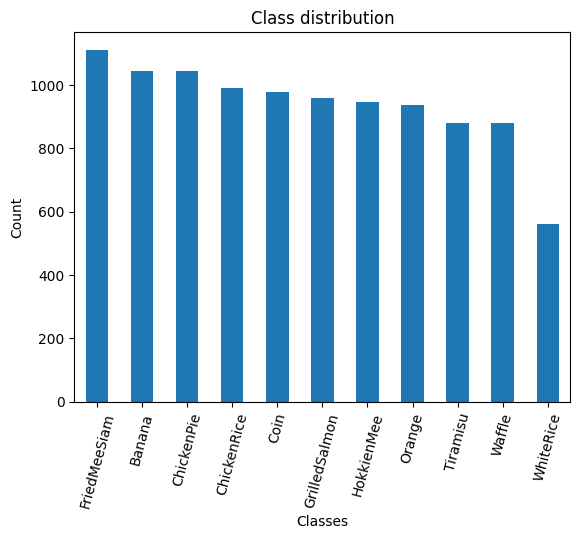

In [163]:
# Get the number of samples for each object class
class_counts = shapes_df['label'].value_counts()

# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_names, rotation=75)  # Set the x-axis tick labels
plt.show()

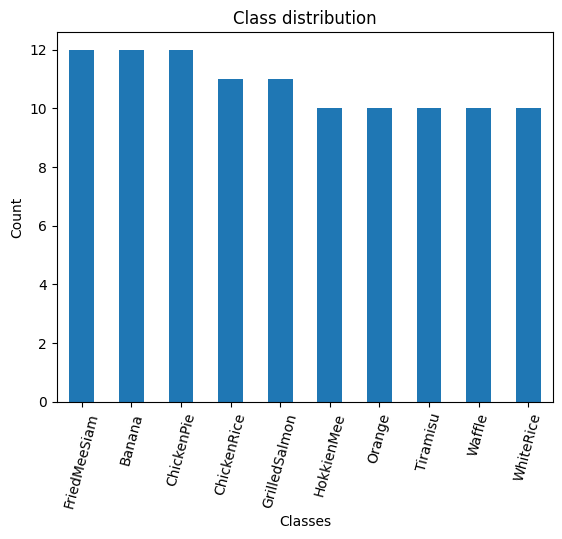

In [164]:
# Get the number of samples for each object class
class_counts_valid = shapes_df_valid['label'].value_counts()

# Plot the distribution
class_counts_valid.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts_valid.index)), class_names_valid, rotation=75)  # Set the x-axis tick labels
plt.show()

In [165]:
# Prepend a `background` class to the list of class names
class_names = ['background']+class_names

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,background
1,FriedMeeSiam
2,Banana
3,ChickenPie
4,ChickenRice
5,Coin
6,GrilledSalmon
7,HokkienMee
8,Orange
9,Tiramisu


In [166]:
# Prepend a `background` class to the list of class names
class_names_valid = ['background']+class_names_valid

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names_valid)

,0
0,background
1,FriedMeeSiam
2,Banana
3,ChickenPie
4,ChickenRice
5,GrilledSalmon
6,HokkienMee
7,Orange
8,Tiramisu
9,Waffle


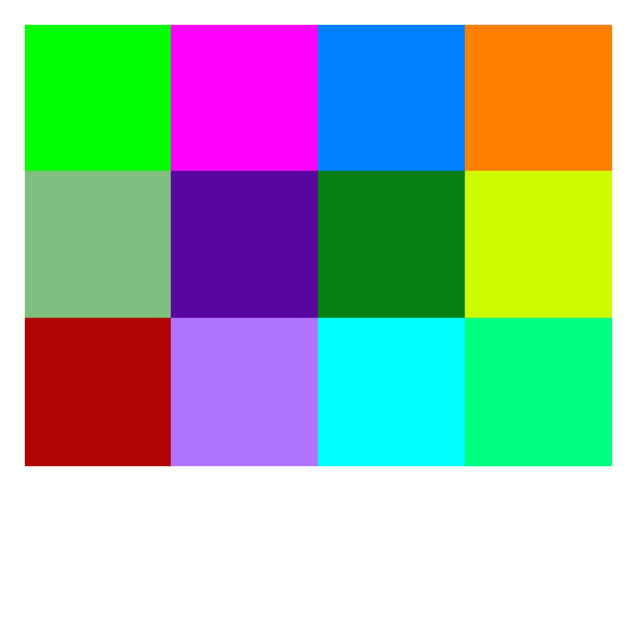

In [167]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

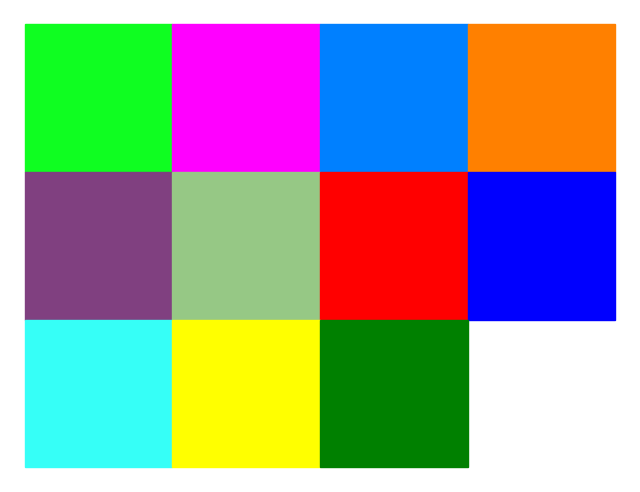

In [168]:
# Generate a list of colors with a length equal to the number of labels
colors_valid = distinctipy.get_colors(len(class_names_valid))

# Make a copy of the color map in integer format
int_colors_valid = [tuple(int(c*255) for c in color_valid) for color_valid in colors_valid]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors_valid)

In [169]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


In [170]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

Image Dims: (640, 640)


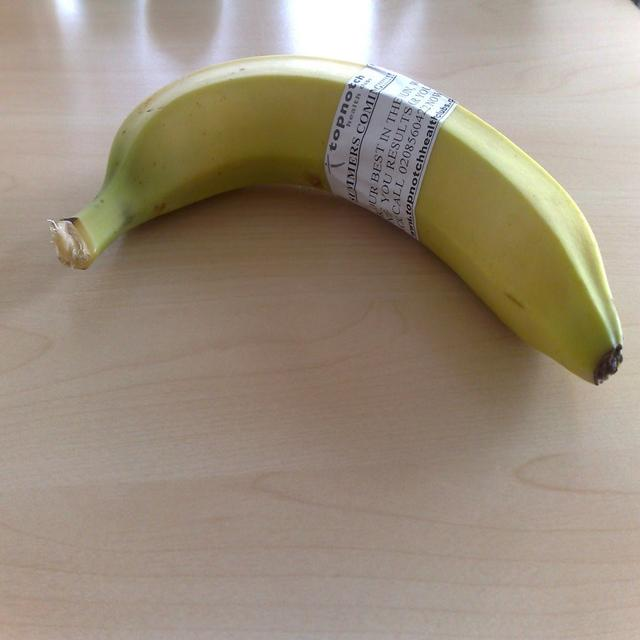

In [171]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[56]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

Image Dims: (640, 640)


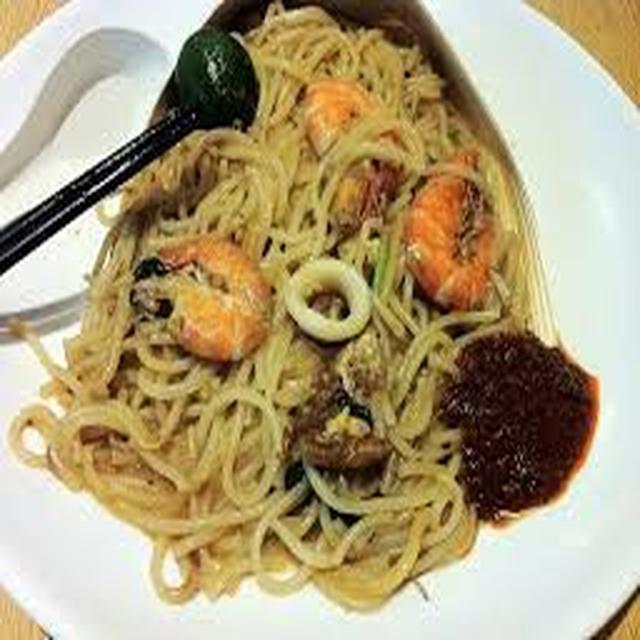

In [172]:
# Get the file ID of the first image file
file_id_valid = list(img_dict_valid.keys())[56]

# Open the associated image file as a RGB image
sample_img_valid = Image.open(img_dict_valid[file_id_valid]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img_valid.size}")

# Show the image
sample_img_valid

In [173]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,Banana13
version,5.0.1
flags,{}
shapes,"[{'label': 'Banana', 'points': [[122.32911392405063, 238.9873417721519], [201.72151898734177, 204.15189873417722], [266.53164556962025, 184.70886075949366], [345.9240506329114, 209.0126582278481], [405.0632911392405, 234.9367088607595], [454.4810126582279, 273.82278481012656], [502.2784810126582, 323.24050632911394], [548.4556962025316, 355.64556962025324], [594.632911392405, 385.62025316455697], [627.0379746835443, 363.746835443038], [616.506329113924, 310.27848101265823], [594.632911392405, 227.64556962025318], [531.4430379746835, 158.78481012658227], [469.0632911392405, 105.31645569620252], [374.27848101265823, 62.37974683544303], [273.82278481012656, 54.278481012658226], [187.13924050632912, 71.29113924050633], [118.27848101265823, 112.60759493670886], [102.07594936708861, 184.70886075949366], [46.177215189873415, 225.21518987341773], [62.37974683544303, 269.7721518987342], [89.1139240506329, 269.7721518987342]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]"
imagePath,Banana13.jpg
imageData,None
imageHeight,640
imageWidth,640


In [174]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df_valid.loc[file_id_valid].to_frame()

,HokkienMee59
version,5.0.1
flags,{}
shapes,"[{'label': 'HokkienMee', 'points': [[254.37974683544303, 23.49367088607595], [286.7848101265823, 9.721518987341772], [362.126582278481, 23.49367088607595], [405.873417721519, 37.265822784810126], [464.2025316455696, 110.17721518987342], [449.62025316455697, 125.56962025316454], [500.6582278481012, 176.6075949367089], [508.75949367088606, 306.2278481012658], [482.0253164556962, 354.02531645569627], [470.6835443037975, 432.60759493670884], [470.6835443037975, 518.4810126582279], [443.1392405063291, 574.379746835443], [330.53164556962025, 595.4430379746835], [160.40506329113924, 578.4303797468355], [122.32911392405063, 522.5316455696202], [38.075949367088604, 469.873417721519], [61.56962025316456, 399.3924050632911], [79.39240506329114, 304.60759493670884], [109.36708860759494, 232.50632911392404], [156.35443037974684, 157.9746835443038], [193.62025316455697, 128.0], [243.0379746835443, 47.79746835443038]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}]"
imagePath,HokkienMee59.jpg
imageData,None
imageHeight,640
imageWidth,640


In [175]:
from windows_utils import create_polygon_mask

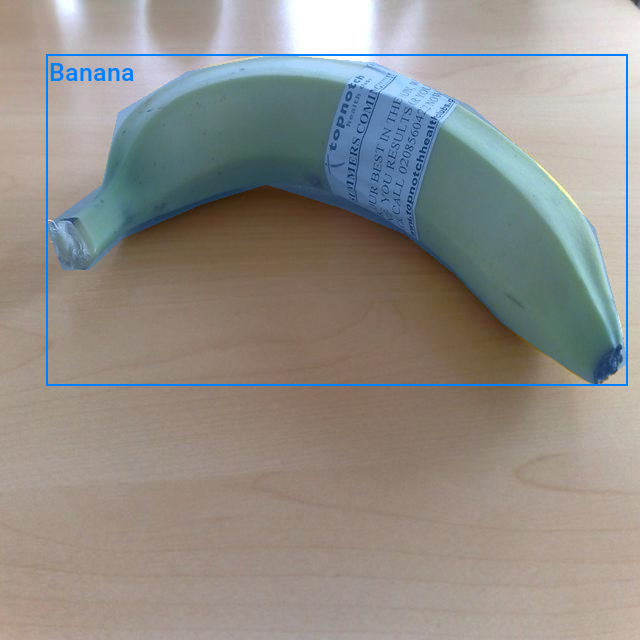

In [176]:
# Extract the labels for the sample
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
# Extract the polygon points for segmentation mask
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
# Format polygon points for PIL
xy_coords = [[tuple(p) for p in points] for points in shape_points]
# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
# Generate bounding box annotations from segmentation masks
bboxes = torchvision.ops.masks_to_boxes(masks)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img), 
    masks=masks, 
    alpha=0.3, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=bboxes, 
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

In [177]:
# Initialize a Mask R-CNN model with pretrained weights
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Get the number of input features for the classifier
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=len(class_names))

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=len(class_names))

# Set the model's device and data type
model.to(device=device, dtype=dtype);

# Add attributes to store the device and model name for later reference
model.device = device
model.name = 'maskrcnn_resnet50_fpn_v2'

In [178]:
test_inp = torch.randn(1, 3, 256, 256).to(device)

summary_df = markdown_to_pandas(f"{get_module_summary(model.eval(), [test_inp])}")

# # Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[summary_df.index == 0]

summary_df.drop(['In size', 'Out size', 'Contains Uninitialized Parameters?'], axis=1)

c:\Users\ivanc\maskrcnn\myenv\lib\site-packages\torchtnt\utils\module_summary.py:271: UserWarning: Backward FLOPs are only computed if module foward returns a tensor.
  warnings.warn(


,Type,# Parameters,# Trainable Parameters,Size (bytes),Forward FLOPs
0,MaskRCNN,45.9 M,45.7 M,183 M,331 G


In [179]:
# Get the list of image IDs
img_keys_train = list(img_dict.keys())
img_keys_valid = list(img_dict_valid.keys())

# # Shuffle the image IDs
# random.shuffle(img_keys)

# # Define the percentage of the images that should be used for training
# train_pct = 0.8
# val_pct = 0.2

# Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_keys_train))
val_split = int(len(img_keys_valid))

# Split the subset of image paths into training and validation sets
# train_keys = img_keys[:train_split]
# val_keys = img_keys[train_split:]

# Print the number of images in the training and validation sets
# pd.Series({
#     "Training Samples:": len(train_keys),
#     "Validation Samples:": len(val_keys)
# }).to_frame().style.hide(axis='columns')

In [180]:
# Set training image size
train_sz = 640

In [181]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

In [182]:
# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

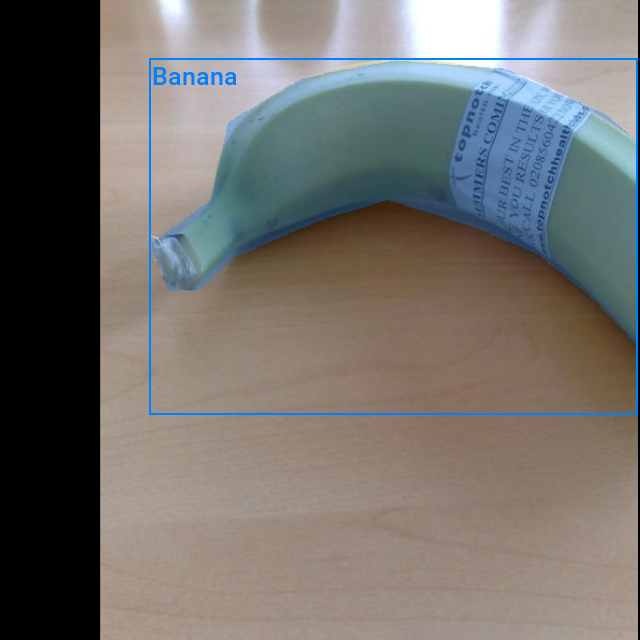

Source Image:,"(640, 640)"
Cropped Image:,"(500, 595)"
Resized Image:,"(537, 639)"
Padded Image:,"(639, 639)"
Resized Padded Image:,"(640, 640)"


In [183]:
# Extract the labels for the sample
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
# Extract the polygon points for segmentation mask
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
# Format polygon points for PIL
xy_coords = [[tuple(p) for p in points] for points in shape_points]
# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
# Generate bounding box annotations from segmentation masks
bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=sample_img.size[::-1])

# Get colors for dataset sample
sample_colors = [int_colors[i] for i in [class_names.index(label) for label in labels]]

# Prepare mask and bounding box targets
targets = {
    'masks': Mask(masks), 
    'boxes': bboxes, 
    'labels': torch.Tensor([class_names.index(label) for label in labels])
}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img), 
    masks=targets['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=targets['boxes'], 
    labels=[class_names[int(label.item())] for label in targets['labels']], 
    colors=sample_colors
)

# # Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

In [184]:
from windows_utils import StudentIDDataset

In [189]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}
class_to_idx_valid = {c: i for i, c in enumerate(class_names_valid)}

train_keys = img_keys_train
print(train_keys)
val_keys = img_keys_valid

# Instantiate the datasets using the defined transformations
train_dataset = StudentIDDataset(train_keys, annotation_df, img_dict, class_to_idx)
valid_dataset = StudentIDDataset(val_keys, annotation_df_valid, img_dict_valid, class_to_idx_valid)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')

['06VM8ESXIQVJVXJ6KDCTI2QG', '06VM8ESXIQVJVXJ6KDCTI2QG_aug_0', '06VM8ESXIQVJVXJ6KDCTI2QG_aug_1', '06VM8ESXIQVJVXJ6KDCTI2QG_aug_2', '06VM8ESXIQVJVXJ6KDCTI2QG_aug_3', '06VM8ESXIQVJVXJ6KDCTI2QG_aug_4', '06VM8ESXIQVJVXJ6KDCTI2QG_aug_5', '06VM8ESXIQVJVXJ6KDCTI2QG_aug_6', '06VM8ESXIQVJVXJ6KDCTI2QG_aug_7', '06VM8ESXIQVJVXJ6KDCTI2QG_aug_8', '06VM8ESXIQVJVXJ6KDCTI2QG_aug_9', '07KOXNHR87CY8H4FJADCX6I2', '07KOXNHR87CY8H4FJADCX6I2_aug_0', '07KOXNHR87CY8H4FJADCX6I2_aug_1', '07KOXNHR87CY8H4FJADCX6I2_aug_2', '07KOXNHR87CY8H4FJADCX6I2_aug_3', '07KOXNHR87CY8H4FJADCX6I2_aug_4', '07KOXNHR87CY8H4FJADCX6I2_aug_5', '07KOXNHR87CY8H4FJADCX6I2_aug_6', '07KOXNHR87CY8H4FJADCX6I2_aug_7', '07KOXNHR87CY8H4FJADCX6I2_aug_8', '07KOXNHR87CY8H4FJADCX6I2_aug_9', '8CQQT9F4E43UH076I63868V0', '8CQQT9F4E43UH076I63868V0_aug_0', '8CQQT9F4E43UH076I63868V0_aug_1', '8CQQT9F4E43UH076I63868V0_aug_2', '8CQQT9F4E43UH076I63868V0_aug_3', '8CQQT9F4E43UH076I63868V0_aug_4', '8CQQT9F4E43UH076I63868V0_aug_5', '8CQQT9F4E43UH076I63868V0_aug_6

Training dataset size:,9350
Validation dataset size:,100


In [195]:
dataset_sample = train_dataset[0]
print(dataset_sample[0])
# Get colors for dataset sample
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks( 
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    masks=dataset_sample[1]['masks'], 
    alpha=0.3, 
    colors=sample_colors
)


# Annotate the sample image with bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)

<PIL.Image.Image image mode=RGB size=640x640 at 0x2B630DC1C30>


TypeError: unsupported operand type(s) for *: 'Image' and 'int'